In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyclifford as pc
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
import pyclifford as pc
from pyclifford.utils import mask, condense, pauli_diagonalize1,stabilizer_measure
from pyclifford.paulialg import Pauli, pauli, PauliMonomial, pauli_zero
from pyclifford.stabilizer import (StabilizerState, CliffordMap,
    zero_state, identity_map, clifford_rotation_map, random_clifford_map)

In [3]:
def random_layers(N_QUBITS,HALF_DEPTH):
    random_layers=[]
    for i in range (int(HALF_DEPTH)):
        random_layer=[]
        if i%2==0:
            for j in range (int(np.floor(N_QUBITS/2))):
                gate=pc.CliffordGate(j*2,j*2+1)
                gate.set_forward_map(pc.random_clifford_map(2))
                random_layer.append(gate)
            random_layers.append(random_layer)
        elif i%2==1:
            for j in range (int(np.floor(N_QUBITS/2))):
                gate=pc.CliffordGate(j*2+1,(j*2+2)%N_QUBITS)
                gate.set_forward_map(pc.random_clifford_map(2))
                random_layer.append(gate)
            random_layers.append(random_layer)
    return random_layers

In [4]:
def measure_layers(N_QUBITS,HALF_DEPTH,theta):
    measure_layers=[]
    for i in range (int(HALF_DEPTH)):
        measure_layer=[]
        for j in range (int(N_QUBITS)):
            if theta[-i + HALF_DEPTH - 1][j]==1:
                measure_layer.append(j)
        measure_layers.append(measure_layer)
    return measure_layers

In [5]:
def create_circuit(N_QUBITS,HALF_DEPTH,random_layers,measure_layers):
    circ = pc.circuit.Circuit(N_QUBITS)
    for i in range(int(HALF_DEPTH)):
        for j in range(int(np.floor(N_QUBITS/2))):
            circ.take(random_layers[i][j])
        if measure_layers[i]!=[]:
            qubits=tuple(measure_layers[i])
            circ.measure(*qubits)
            
    return circ

In [6]:
def averaged_EE(state_final):
    EE_positions=[]
    for i in range(0,state_final.N):
        EE_positions.append([int(i),int(i+1)%state_final.N])
        
    EE_list=[]
    for i in range(0,len(EE_positions)):
        EE_list.append(state_final.entropy(EE_positions[i]))
    
    averaged_EE=np.mean(EE_list)
        
    return averaged_EE #, EE_positions, EE_list

In [7]:
def penalty(x,penalty_slope):
    return 2*(0.5-(1/(1+np.exp(-penalty_slope*x))-0.5))

In [8]:
class Disentangler(gym.Env):
    """
    Reinforcement learning environment for the disentangler.
    """
    
    def __init__(self, n_qubits, half_depth, positive_reward, penalty_slope):
        super(Disentangler, self).__init__()
        
        self.N_QUBITS = n_qubits
        self.HALF_DEPTH = half_depth
        self.DEPTH = 2*half_depth
        #self.positive_reward = positive_reward
        self.penalty_slope = penalty_slope
        
        self.action_space = gym.spaces.Discrete(self.N_QUBITS * self.HALF_DEPTH)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)

        self.random_layers=random_layers(self.N_QUBITS,self.HALF_DEPTH)
        self.theta = np.zeros((self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)
        self.measure_layers=measure_layers(self.N_QUBITS,self.HALF_DEPTH,self.theta)
        
    def step(self, action):
        # Initialize reward and done
        reward = 0
        done = False
        truncate = False

        # Apply the action
        h = np.zeros(self.N_QUBITS * self.HALF_DEPTH, dtype=np.int8)
        h[action] = 1
        h = h.reshape((self.HALF_DEPTH, self.N_QUBITS))
        self.theta = (self.theta + h) % 2

        # Calculate entropy (assumes circuit is a predefined function)
        self.measure_layers=measure_layers(self.N_QUBITS, self.HALF_DEPTH, self.theta)
        circ = create_circuit(self.N_QUBITS, self.HALF_DEPTH, self.random_layers, self.measure_layers)

        state_initial = pc.stabilizer.zero_state(self.N_QUBITS)
        state_final = circ.forward(state_initial)

        entropy = averaged_EE(state_final)

        
        if entropy == 0:
            m_per_layer = [np.sum(layer) for layer in self.theta]
            cost = [m_per_layer[i]*penalty(i,self.penalty_slope) for i in range(self.HALF_DEPTH)]
            penalty_list=[penalty(i,self.penalty_slope) for i in range(self.HALF_DEPTH)]
            reward = 1 - sum(cost)/(self.N_QUBITS*sum(penalty_list))
            #reward = self.positive_reward - np.sum(cost)/(self.N_QUBITS*self.DEPTH)
            done = True
        
        # Return the state, reward, done flag, truncate flag, and info
        info = {}
        return self.theta, reward, done, truncate, info
    
    def return_entropy(self):
        # Calculate entropy (assumes circuit is a predefined function)
        self.measure_layers=measure_layers(self.N_QUBITS, self.HALF_DEPTH, self.theta)
        circ = create_circuit(self.N_QUBITS, self.HALF_DEPTH, self.random_layers, self.measure_layers)

        state_initial = pc.stabilizer.zero_state(self.N_QUBITS)
        state_final = circ.forward(state_initial)

        entropy = averaged_EE(state_final)
        
        return entropy
        
    
    def reset(self, seed=None):
        # Seed the random number generator if a seed is provided
        if seed is not None:
            np.random.seed(seed)
        
        # Reset the state to an all-zero matrix
        self.theta = np.zeros((self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)

        # Reset the random layers to another random layers
        self.random_layers=random_layers(self.N_QUBITS,self.HALF_DEPTH)
        
        info = {}
        return self.theta, info
    
    def render(self):
        print()

    def close(self):
        # Optional: Implement any cleanup
        pass


In [11]:
# ppo parameters
ts = 0.5*1e6
lr = 0.001
ec = 0.01
#ec_list=[0.01,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]

# circuit parameters
#N_QUBITS=10
N_QUBITS_list=[10]#[2,3,4,5,6,7,8,9,10]#,15,20,25,30]

#HALF_DEPTH=2
#DEPTH=int(2*HALF_DEPTH)
HALF_DEPTH_list=[30]#[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
DEPTH_list=[int(2*HALF_DEPTH_list[i]) for i in range(np.size(HALF_DEPTH_list))]

positive_reward = 50
penalty_slope = 0#[0,0.5,1,2,3,4,5]

#num_full_learning = 1

In [ ]:
#This part is to check the stability of learning
#model_set=[[] for i in range(np.size(HALF_DEPTH_list))]

for i in range(np.size(N_QUBITS_list)):
    N_QUBITS = N_QUBITS_list[i]
    print("N_QUBITS",'=',N_QUBITS)
    for j in range(np.size(HALF_DEPTH_list)):
        HALF_DEPTH = HALF_DEPTH_list[j]
        print("HALF_DEPTH",'=',HALF_DEPTH)
        env = Disentangler(N_QUBITS,HALF_DEPTH,positive_reward,penalty_slope)

        env.reset()
        model = PPO('MlpPolicy', env, verbose=0, tensorboard_log="./tensorboard_files", learning_rate=lr, ent_coef=ec)

        model.learn(total_timesteps=ts, tb_log_name="{N_QUBITS}x{HALF_DEPTH}_tb_{ts}_pr_{positive_reward}_ps_{penalty_slope}".format(N_QUBITS=N_QUBITS, HALF_DEPTH=HALF_DEPTH, ts=ts, positive_reward=positive_reward, penalty_slope=penalty_slope))
        model_path = "./models/{N_QUBITS}x{HALF_DEPTH}_tb_{ts}_pr_{positive_reward}_ps_{penalty_slope}".format(N_QUBITS=N_QUBITS, HALF_DEPTH=HALF_DEPTH, ts=ts, positive_reward=positive_reward, penalty_slope=penalty_slope)
        #model_set[i].append(model_path)
        model.save(model_path)
        print("learning done")
        


N_QUBITS = 10
HALF_DEPTH = 30


(0.6582573641864072,
 array([[1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0]]))

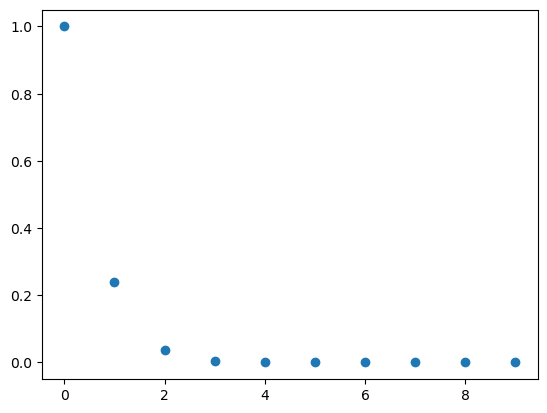

In [24]:
HALF_DEPTH = 10
penalty_slope=2

theta =np.random.randint(2, size=(N_QUBITS,HALF_DEPTH))

m_per_layer = [np.sum(layer) for layer in theta]
cost = [m_per_layer[i]*penalty(i,penalty_slope) for i in range(HALF_DEPTH)]

x=range(HALF_DEPTH)
penalty_list=[penalty(i,penalty_slope) for i in range(HALF_DEPTH)]
reward = 1 - sum(cost)/(N_QUBITS*sum(penalty_list))

plt.scatter(x,penalty_list)
reward,theta